# Imports

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Load dataset

In [3]:
train_data = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.63MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


In [4]:
train_data.data.max()

tensor(255, dtype=torch.uint8)

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
# Test data
test_data = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [11]:
# Number of classes
K = len(set(train_data.targets.numpy()))
print(f"Number of classes: {K}")

Number of classes: 10


In [13]:
# Model Definition
class CNN(nn.Module):

  def __init__(self, k):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )

    # Dense Layers
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(512, K))

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1) #out.size = batch size
    out = self.dense_layers(out)
    return out

In [14]:
# Model Instantiation
model = CNN(K)

In [15]:
# Deploying model on GPU if required
# I have used the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [16]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [18]:
# Data Loader
# Will generate batches in the training loop
# Also helps with shuffling the data

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size = batch_size,
                                          shuffle=False)

In [25]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # Move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forwards Pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss =  []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    # Saving Losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0

    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f},\
    Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses



In [26]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15
)

Epoch 1/15, Train Loss: 0.3426,    Test Loss: 0.3381, Duration: 0:00:33.750649
Epoch 2/15, Train Loss: 0.3151,    Test Loss: 0.3222, Duration: 0:00:32.742195
Epoch 3/15, Train Loss: 0.2938,    Test Loss: 0.3266, Duration: 0:00:33.914270
Epoch 4/15, Train Loss: 0.2769,    Test Loss: 0.2987, Duration: 0:00:33.015319
Epoch 5/15, Train Loss: 0.2578,    Test Loss: 0.2881, Duration: 0:00:35.673307
Epoch 6/15, Train Loss: 0.2457,    Test Loss: 0.2967, Duration: 0:00:46.936692
Epoch 7/15, Train Loss: 0.2308,    Test Loss: 0.2752, Duration: 0:00:33.926752
Epoch 8/15, Train Loss: 0.2179,    Test Loss: 0.2866, Duration: 0:00:37.819454
Epoch 9/15, Train Loss: 0.2051,    Test Loss: 0.2820, Duration: 0:00:37.643348
Epoch 10/15, Train Loss: 0.1970,    Test Loss: 0.2745, Duration: 0:00:34.299070
Epoch 11/15, Train Loss: 0.1865,    Test Loss: 0.2987, Duration: 0:00:33.717784
Epoch 12/15, Train Loss: 0.1777,    Test Loss: 0.2816, Duration: 0:00:35.680035
Epoch 13/15, Train Loss: 0.1680,    Test Loss: 0.

# Model Evaluation

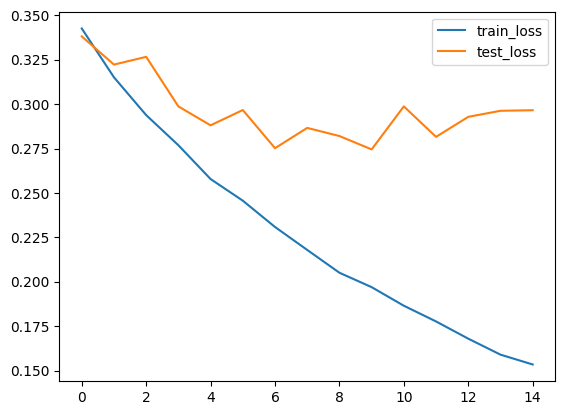

In [27]:
# Plotting train/test loss curves

plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.show()

In [28]:
# Model Accuracy

model.eval()

n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
  # Move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 0.9630, Test acc: 0.9048


In [29]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[829   2  21  19   4   2 119   0   4   0]
 [  1 974   1  17   3   0   2   0   2   0]
 [ 14   0 856   9  32   1  86   0   2   0]
 [ 15   4  12 916  30   0  22   0   1   0]
 [  0   1  53  16 812   0 116   0   2   0]
 [  1   0   0   1   0 969   0  17   0  12]
 [ 79   0  45  30  49   0 789   0   8   0]
 [  0   0   0   0   0   9   0 965   0  26]
 [  1   0   5   5   2   2   4   3 978   0]
 [  0   0   0   0   0   7   1  32   0 960]]


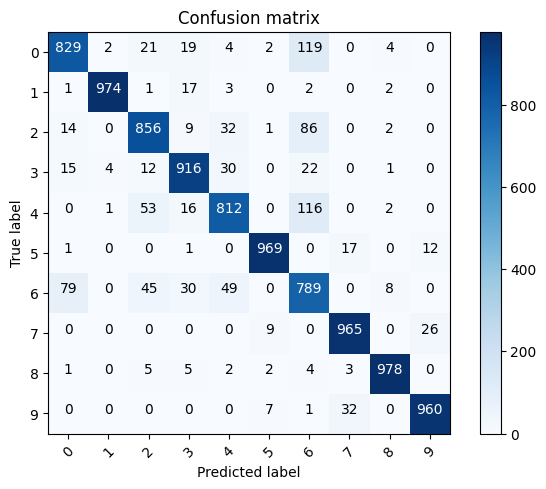

In [31]:
# get all predictions in an array and plot confusion matrix

x_test = test_data.data.numpy()
y_test = test_data.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [32]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

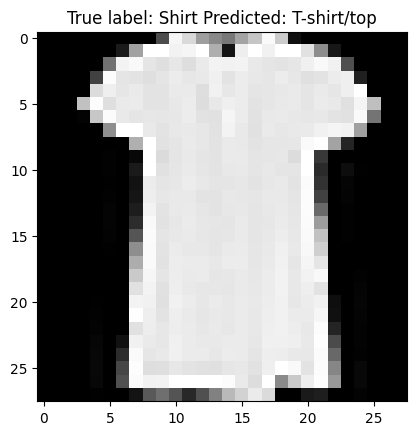

In [33]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

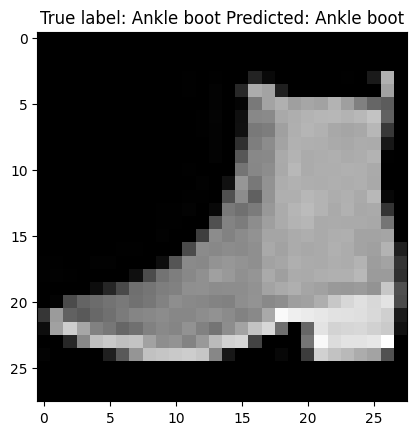

In [36]:
# Properly classified
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
classified_idx = np.where(p_test == y_test)[0]
i = np.random.choice(classified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));